# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
import copy
from omegaconf import OmegaConf, open_dict
import numpy as np
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "balanced"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 1
    cfg.case.model = "vit_small"
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True
    
    cfg.attack.optim.max_iterations = 24000
    
    cfg.seed = 233

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture vit_small loaded with 22,050,664 parameters and 0 buffers.
Overall this is a data ratio of     146:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: vit_small
        model state: trained
        

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    Augmentations: 

In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: vit_small
        model state: trained
        

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: soft
        step_size: 0.1
        boxed: True
        max_iterations: 24000
        step_size_decay: cosine-deca

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

# replace layer norm in ViT with Identity
from torch import nn
server.original_model.model.blocks[0].norm1 = nn.Identity()
server.reset_model()
user = breaching.cases.users.construct_user(server.model, loss_fn, cfg.case, setup)

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
# server.reconfigure_model('cls_attack', extra_info=extra_info)

In [7]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

In [8]:
# analytic attack

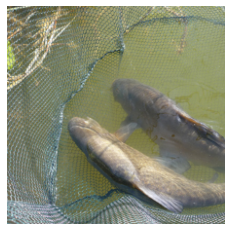

In [9]:
user.plot(true_user_data)

### Reconstruct user data:

In [240]:
target_idx = np.where(t_labels == cls_to_obtain)[0]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][target_idx]
tmp_true_user_data['labels'] = true_user_data['labels'][target_idx]

In [11]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0441 | PSNR: 14.10 | FMSE: 9.1106e+02 | LPIPS: 0.51|
 R-PSNR: 14.29 | IIP-pixel: 62.50% | SSIM: 0.3281 | max R-PSNR: 17.23 | max SSIM: 0.4036 | Label Acc: 100.00%


In [ ]:
user.plot(reconstructed_user_data)

In [45]:
qkv_g = shared_data["gradients"][4]
q_g, k_g, v_g = qkv_g.reshape(3, -1, qkv_g.shape[-1]).unbind()
z_g = shared_data["gradients"][3]

In [47]:
z_g.shape

torch.Size([384])

In [210]:
server.model.model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): Identity()
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_feat

In [11]:
for name, param in server.model.named_parameters():
    print(name, param.shape)

model.cls_token torch.Size([1, 1, 384])
model.pos_embed torch.Size([1, 197, 384])
model.patch_embed.proj.weight torch.Size([384, 3, 16, 16])
model.patch_embed.proj.bias torch.Size([384])
model.blocks.0.attn.qkv.weight torch.Size([1152, 384])
model.blocks.0.attn.qkv.bias torch.Size([1152])
model.blocks.0.attn.proj.weight torch.Size([384, 384])
model.blocks.0.attn.proj.bias torch.Size([384])
model.blocks.0.norm2.weight torch.Size([384])
model.blocks.0.norm2.bias torch.Size([384])
model.blocks.0.mlp.fc1.weight torch.Size([1536, 384])
model.blocks.0.mlp.fc1.bias torch.Size([1536])
model.blocks.0.mlp.fc2.weight torch.Size([384, 1536])
model.blocks.0.mlp.fc2.bias torch.Size([384])
model.blocks.1.norm1.weight torch.Size([384])
model.blocks.1.norm1.bias torch.Size([384])
model.blocks.1.attn.qkv.weight torch.Size([1152, 384])
model.blocks.1.attn.qkv.bias torch.Size([1152])
model.blocks.1.attn.proj.weight torch.Size([384, 384])
model.blocks.1.attn.proj.bias torch.Size([384])
model.blocks.1.norm2

In [10]:
for i in shared_data['gradients']:
    print(i.shape)

torch.Size([1, 1, 384])
torch.Size([1, 197, 384])
torch.Size([384, 3, 16, 16])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 1536])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 1536])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 1536])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 

In [55]:
input = torch.zeros([1, 3, 224, 224])
proj = nn.Conv2d(3, 384, kernel_size=16, stride=16)

In [56]:
proj(input).shape

torch.Size([1, 384, 14, 14])

In [257]:
# get patch embeddings
qkv_w = server.model.model.blocks[0].attn.qkv.weight.detach()
q_w, k_w, v_w = qkv_w.reshape(3, -1, qkv_w.shape[-1]).unbind()
qkv_g = shared_data["gradients"][4]
q_g, k_g, v_g = qkv_g.reshape(3, -1, qkv_g.shape[-1]).unbind()
A = shared_data["gradients"][1].detach().squeeze()[1:]
pos_embed = server.model.model.pos_embed.detach().squeeze()

b = q_w.T @ q_g + k_w.T @ k_g + v_w.T @ v_g
# b = q_g.T @ q_w + k_g.T @ k_w + v_g.T @ v_w
z = torch.linalg.lstsq(b.T, A.T).solution
z = z.T
z -= pos_embed[1:]

# get img back
em_w = server.model.model.patch_embed.proj.weight.detach()
em_w = em_w.reshape((em_w.shape[0], -1))
em_b = server.model.model.patch_embed.proj.bias.detach()
z -= em_b
x = torch.linalg.lstsq(em_w, z.T).solution
# x = torch.div(z, em_w)
x = x.T
x = x.reshape((3, 224, 224))

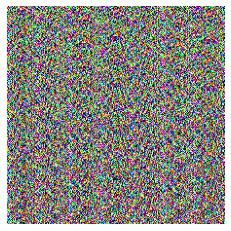

In [258]:
user.plot({"data": x.unsqueeze(0), "labels": None})

In [259]:
x.shape

torch.Size([3, 224, 224])

In [231]:
z.shape

torch.Size([196, 384])

In [232]:
em_w.shape

torch.Size([384, 768])

In [225]:
q_w.shape

torch.Size([384, 384])

In [226]:
A.shape

torch.Size([196, 384])

In [227]:
z

tensor([[ 0.5976, -0.1663,  0.1626,  ...,  0.4348,  0.0203,  0.2516],
        [ 1.1092, -0.0784,  0.0960,  ...,  0.2853, -0.0040,  0.1047],
        [ 0.9450, -0.1293,  0.0792,  ...,  0.6947,  0.0797,  0.0603],
        ...,
        [ 0.7676,  0.0652, -0.1219,  ...,  0.0296,  0.0709, -0.0296],
        [ 0.6467,  0.0485, -0.1352,  ...,  0.2081,  0.1046, -0.0344],
        [ 0.0146, -0.0307, -0.1737,  ...,  0.0574,  0.0654, -0.0044]])

In [228]:
t_z = server.model.model.patch_embed(true_user_data['data']) + pos_embed[1:]
t_z

tensor([[[ 0.4384,  0.4393,  2.1911,  ...,  0.4729, -3.4668, -1.8620],
         [-1.0440,  0.0933,  0.0238,  ...,  1.0340,  0.8291, -0.6190],
         [-1.7286,  0.8692,  0.2903,  ..., -1.0451, -0.5777, -0.5821],
         ...,
         [-1.5022, -2.6941,  0.8004,  ...,  0.9464, -0.3517, -1.6625],
         [-1.3019, -0.2279, -0.7941,  ...,  0.4826, -1.0104, -1.2470],
         [-0.5384, -0.4870,  0.7775,  ...,  0.3048, -0.4017, -0.2987]]],
       grad_fn=<AddBackward0>)

In [229]:
torch.nn.CosineSimilarity()(z.reshape(1, -1), t_z.reshape(1, -1))

tensor([-0.4520], grad_fn=<DivBackward0>)

In [159]:
torch.linalg.pinv(A).max()

tensor(523.7611)

In [160]:
z

tensor([[  2.4330,   0.9388,   3.5548,  ...,  22.8002,  -3.4297,   3.3859],
        [ -6.8817,   3.2952, -11.7829,  ..., -34.0361,   2.6728,  -3.2815],
        [  1.8733,   3.1819,   0.3284,  ...,   5.5879,  -0.4072,   1.5085],
        ...,
        [ 10.4271,  -8.4624,  18.6379,  ...,  65.0078, -10.0787,   3.4855],
        [ -5.3025,  10.5276, -16.0848,  ..., -53.5088,   7.2799,  -6.7689],
        [ -1.8349,   3.4652,  -5.3137,  ..., -11.8074,   1.5133,   2.4694]])

In [161]:
server.model.model.patch_embed(true_user_data['data']) + pos_embed[1:]

tensor([[[ 0.4384,  0.4393,  2.1911,  ...,  0.4729, -3.4668, -1.8620],
         [-1.0440,  0.0933,  0.0238,  ...,  1.0340,  0.8291, -0.6190],
         [-1.7286,  0.8692,  0.2903,  ..., -1.0451, -0.5777, -0.5821],
         ...,
         [-1.5022, -2.6941,  0.8004,  ...,  0.9464, -0.3517, -1.6625],
         [-1.3019, -0.2279, -0.7941,  ...,  0.4826, -1.0104, -1.2470],
         [-0.5384, -0.4870,  0.7775,  ...,  0.3048, -0.4017, -0.2987]]],
       grad_fn=<AddBackward0>)

In [136]:
t_z = server.model.model.patch_embed(true_user_data['data'])
t_z = t_z.squeeze()

In [151]:
t_b = A.T @ (t_z + pos_embed[1:])

In [152]:
t_b

tensor([[-0.0223, -0.0207, -0.0133,  ..., -0.0007,  0.0071, -0.0089],
        [ 0.0047, -0.0003,  0.0122,  ..., -0.0273, -0.0010, -0.0175],
        [-0.0217, -0.0113, -0.0042,  ...,  0.0224,  0.0033,  0.0075],
        ...,
        [-0.0462, -0.0479,  0.0160,  ...,  0.0703, -0.0052,  0.0484],
        [-0.0007, -0.0123,  0.0098,  ..., -0.0105, -0.0102, -0.0100],
        [-0.0111,  0.0013, -0.0149,  ..., -0.0088,  0.0053, -0.0110]],
       grad_fn=<MmBackward0>)

In [240]:
x

tensor([[[-1.3187e-01, -2.3897e-02,  4.8217e-02,  ..., -1.1256e-01,
           4.5165e-02,  5.6634e-02],
         [-1.2026e-01, -7.0924e-02,  3.4139e-02,  ...,  3.5823e-02,
          -7.5075e-03, -2.1157e-01],
         [ 3.7888e-02, -2.7005e-01, -3.4597e-01,  ...,  8.7946e-02,
           6.5622e-02, -1.7529e-01],
         ...,
         [-9.7657e-02, -4.9571e-01, -5.2506e-01,  ..., -4.5531e-01,
          -1.2837e-01, -1.2279e-01],
         [-3.8641e-01, -2.8317e-01, -1.0653e-01,  ..., -1.6532e-01,
          -1.0098e-01, -2.1603e-01],
         [-1.2560e-02,  1.6065e-01, -2.1594e-01,  ...,  2.4212e-02,
           4.8903e-02,  1.1845e-01]],

        [[-2.5396e-01, -2.4810e-01, -3.3817e-01,  ...,  1.3651e-01,
          -2.5000e-02,  1.5868e-01],
         [ 1.0781e-01,  2.9742e-01,  3.3991e-01,  ..., -4.4004e-01,
           2.0681e-01,  2.0591e-01],
         [-5.5576e-02,  2.1971e-01, -5.3613e-02,  ...,  6.2097e-02,
          -1.9937e-01,  3.2433e-01],
         ...,
         [ 3.2858e-02, -6

In [157]:
em_w.shape

torch.Size([384, 3, 16, 16])

In [158]:
z.shape

torch.Size([197, 384])

In [161]:
em_w.reshape((em_w.shape[0], -1))

torch.Size([384, 768])